In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *
'''
from mpl_toolkits import mplot3d
%matplotlib inline'''

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

'''from sklearn.neighbors import NearestNeighbors
'''
import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
'''from vedo import *'''

'from vedo import *'

In [2]:
def getFashionMNIST(batch_size = 120):
    fashionmnist_data = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))
    train_loader = torch.utils.data.DataLoader(fashionmnist_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)
    return train_loader, train_loader



def getDataset(dataset = "MNIST", batch_size = 120):
    if(dataset == "MNIST"):
        train_loader, test_loader = getMNIST(batch_size)
        noChannels,dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "FashionMNIST"):
        train_loader, test_loader = getFashionMNIST(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "Cifar10"):
        train_loader, test_loader = getCifar10(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    elif(dataset == "cityscapes"):
        train_loader, test_loader = getcityscapes(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    else:
        return None, None, None, None, None    
        
    return train_loader, test_loader, noChannels, dx, dy

In [3]:
train_loader, test_loader, noChannels, dx, dy = getDataset("FashionMNIST")  # FashionMNIST , MNIST

/home/chethan/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for inum, (batch_x, label) in enumerate(train_loader):
    break
    

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


In [7]:
def ImageDistancesFromBarycenter_sliced(batch_x, input_barycenter, remaining_indices):
  wasserDistance = []
  distance_cum_index = np.array([])
  #Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
  #for j in range(batch_x.shape[0]):
  for j in remaining_indices:
    
    wassDistance = ot.sliced_wasserstein_distance(batch_x[j][0], input_barycenter, seed=0)  

    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)

    
    
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  #distance_cum_index gives wasserstein distances of all images from the input barycenter
  distance_cum_index = np.array(distance_cum_index)
  #print(distance_cum_index)

  #remaining_indices = distance_cum_index[:,1][4:]

  #for convergence
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
    
  #if(len(distance_cum_index[:,1]) >= 4):
  f1 = batch_x[int(distance_cum_index[:,1][0])][0].cpu().detach().numpy()
  f2 = batch_x[int(distance_cum_index[:,1][1])][0].cpu().detach().numpy()
  f3 = batch_x[int(distance_cum_index[:,1][2])][0].cpu().detach().numpy()
  f4 = batch_x[int(distance_cum_index[:,1][3])][0].cpu().detach().numpy()  

  A = np.array([f1, f2, f3, f4])
  reg = 0.004
  weights = np.array((0.25, 0.25, 0.25, 0.25))
  next_barycenter = ot.bregman.convolutional_barycenter2d(A, reg, weights) 
  next_barycenter = torch.tensor(next_barycenter)
  next_barycenter = next_barycenter.type(torch.FloatTensor)

  return A, next_barycenter, remaining_indices


Size of batch :  120
Iteration number :  1
Input barycenter : 


/tmp/ipykernel_22399/728281093.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


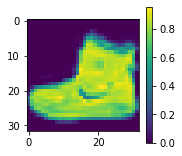

/tmp/ipykernel_22399/728281093.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbours, bary, rem_indices = ImageDistancesFromBarycenter_sliced(batch_x, torch.tensor(bary), rem_indices)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2068: RuntimeWarning: overflow encountered in true_divide
  V = bar[None] / KU
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2068: RuntimeWarning: divide by zero encountered in true_divide
  V = bar[None] / KU
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2074: RuntimeWarning: invalid value encountered in multiply
  err = (V * KU).std(axis=0).sum()
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2088: UserWarning: Convolutional Sinkhorn did not converge. Try a larger number of 

Neighbors of input barycenter :



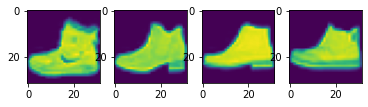

The new barycenter


/tmp/ipykernel_22399/728281093.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


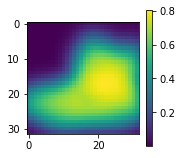

Tracking distance between new barycenter and previous barycenter :  tensor(0.1654)
Iteration number :  2
Input barycenter : 


/tmp/ipykernel_22399/728281093.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bary = torch.tensor(bary)


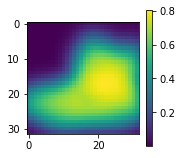

Neighbors of input barycenter :



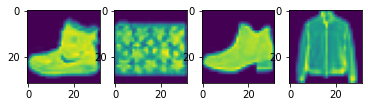

The new barycenter


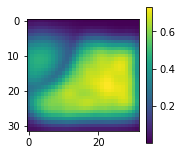

Tracking distance between new barycenter and previous barycenter :  tensor(0.1065)
Iteration number :  3
Input barycenter : 


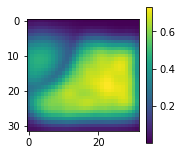

Neighbors of input barycenter :



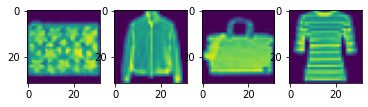

The new barycenter


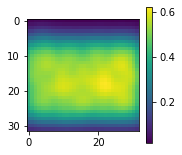

Tracking distance between new barycenter and previous barycenter :  tensor(0.0928)
Iteration number :  4
Input barycenter : 


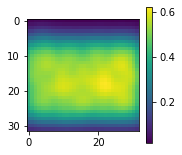

Neighbors of input barycenter :



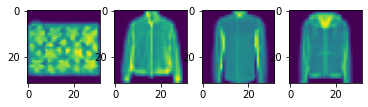

The new barycenter


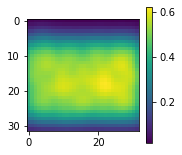

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  5
Input barycenter : 


/tmp/ipykernel_22399/728281093.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)


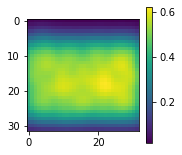

Neighbors of input barycenter :



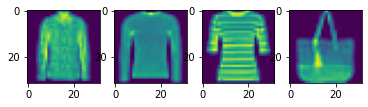

The new barycenter


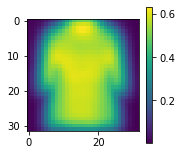

Tracking distance between new barycenter and previous barycenter :  tensor(0.1775)
Iteration number :  6
Input barycenter : 


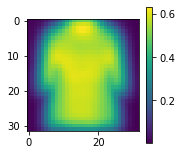

Neighbors of input barycenter :



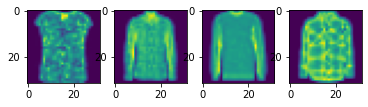

The new barycenter


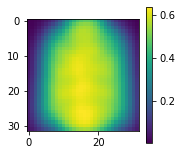

Tracking distance between new barycenter and previous barycenter :  tensor(0.0533)
Iteration number :  7
Input barycenter : 


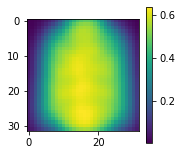

Neighbors of input barycenter :



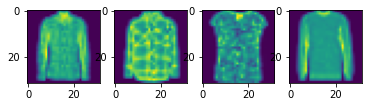

The new barycenter


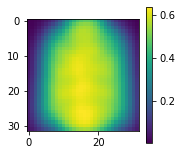

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  8
Input barycenter : 


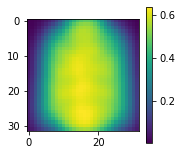

Neighbors of input barycenter :



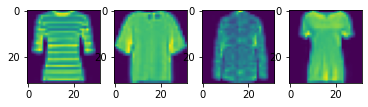

The new barycenter


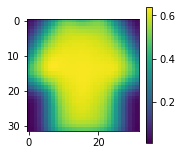

Tracking distance between new barycenter and previous barycenter :  tensor(0.0855)
Iteration number :  9
Input barycenter : 


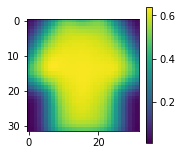

Neighbors of input barycenter :



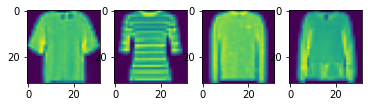

The new barycenter


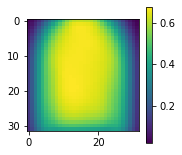

Tracking distance between new barycenter and previous barycenter :  tensor(0.0743)
Iteration number :  10
Input barycenter : 


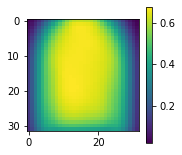

Neighbors of input barycenter :



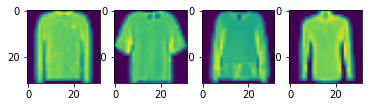

The new barycenter


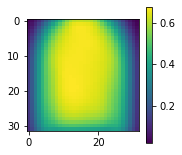

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  11
Input barycenter : 


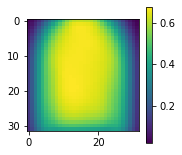

Neighbors of input barycenter :



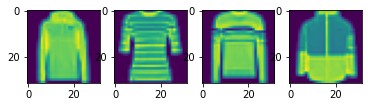

The new barycenter


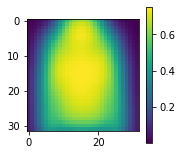

Tracking distance between new barycenter and previous barycenter :  tensor(0.0654)
Iteration number :  12
Input barycenter : 


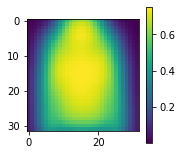

Neighbors of input barycenter :



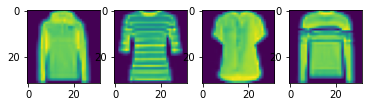

The new barycenter


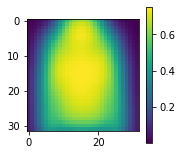

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  13
Input barycenter : 


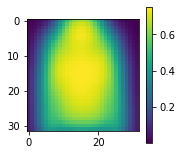

Neighbors of input barycenter :



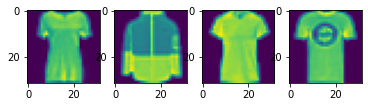

The new barycenter


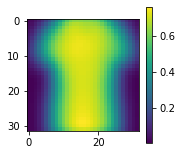

Tracking distance between new barycenter and previous barycenter :  tensor(0.0897)
Iteration number :  14
Input barycenter : 


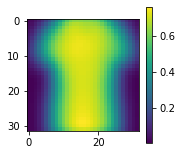

Neighbors of input barycenter :



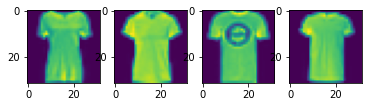

The new barycenter


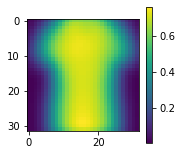

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  15
Input barycenter : 


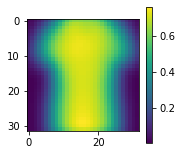

Neighbors of input barycenter :



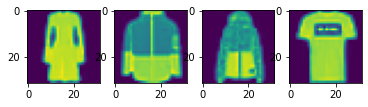

The new barycenter


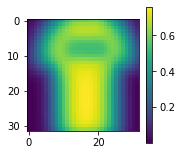

Tracking distance between new barycenter and previous barycenter :  tensor(0.0478)
Iteration number :  16
Input barycenter : 


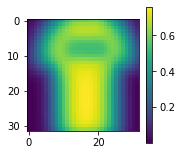

Neighbors of input barycenter :



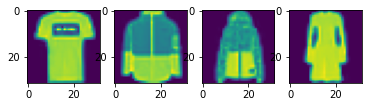

The new barycenter


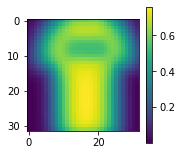

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  17
Input barycenter : 


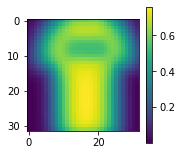

Neighbors of input barycenter :



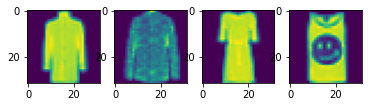

The new barycenter


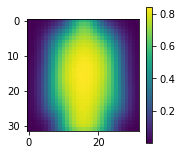

Tracking distance between new barycenter and previous barycenter :  tensor(0.0929)
Iteration number :  18
Input barycenter : 


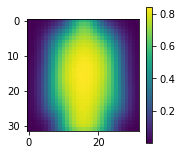

Neighbors of input barycenter :



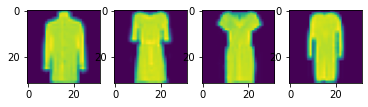

The new barycenter


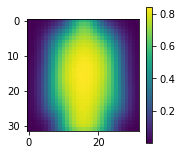

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  19
Input barycenter : 


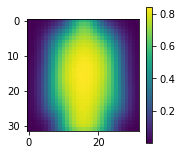

Neighbors of input barycenter :



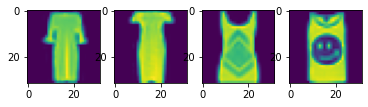

The new barycenter


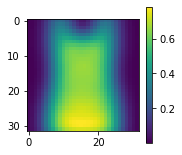

Tracking distance between new barycenter and previous barycenter :  tensor(0.1312)
Iteration number :  20
Input barycenter : 


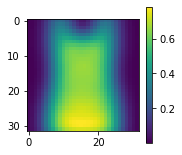

Neighbors of input barycenter :



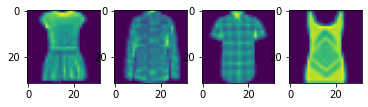

The new barycenter


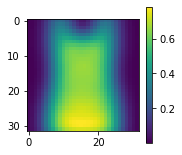

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  21
Input barycenter : 


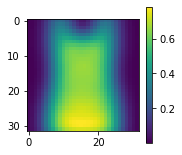

Neighbors of input barycenter :



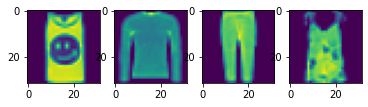

The new barycenter


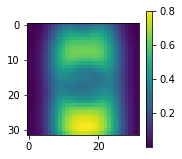

Tracking distance between new barycenter and previous barycenter :  tensor(0.0770)
Iteration number :  22
Input barycenter : 


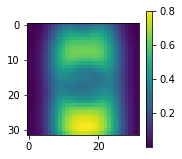

Neighbors of input barycenter :



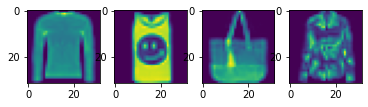

The new barycenter


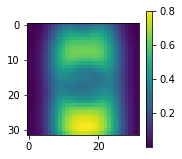

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  23
Input barycenter : 


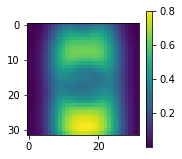

Neighbors of input barycenter :



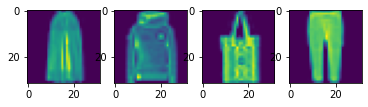

The new barycenter


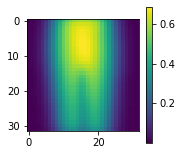

Tracking distance between new barycenter and previous barycenter :  tensor(0.0881)
Iteration number :  24
Input barycenter : 


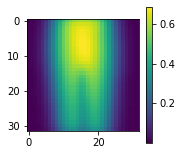

Neighbors of input barycenter :



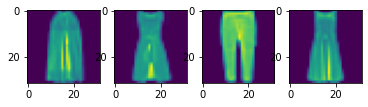

The new barycenter


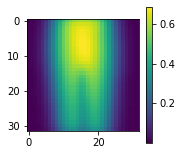

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  25
Input barycenter : 


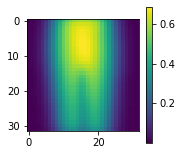

Neighbors of input barycenter :



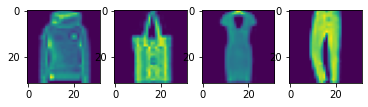

The new barycenter


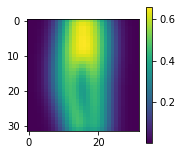

Tracking distance between new barycenter and previous barycenter :  tensor(0.0531)
Iteration number :  26
Input barycenter : 


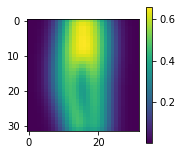

Neighbors of input barycenter :



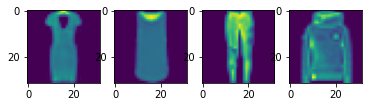

The new barycenter


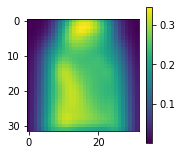

Tracking distance between new barycenter and previous barycenter :  tensor(0.1437)
Iteration number :  27
Input barycenter : 


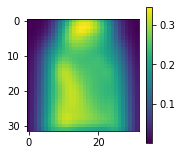

Neighbors of input barycenter :



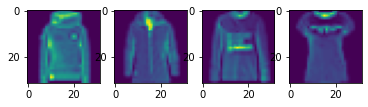

The new barycenter


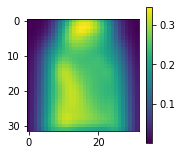

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  28
Input barycenter : 


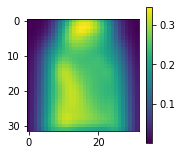

Neighbors of input barycenter :



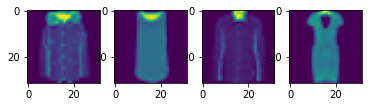

The new barycenter


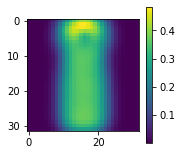

Tracking distance between new barycenter and previous barycenter :  tensor(0.1018)
Iteration number :  29
Input barycenter : 


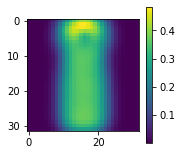

Neighbors of input barycenter :



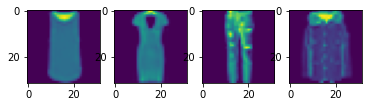

The new barycenter


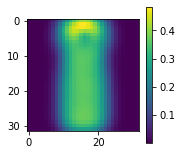

Tracking distance between new barycenter and previous barycenter :  tensor(2.2737e-09)
Iteration number :  30
Input barycenter : 


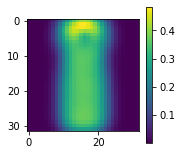

Neighbors of input barycenter :



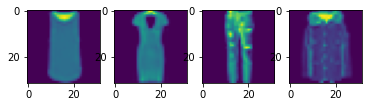

The new barycenter


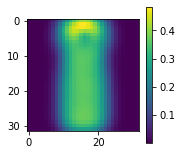

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  31
Input barycenter : 


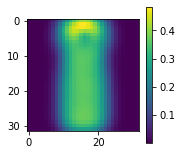

Neighbors of input barycenter :



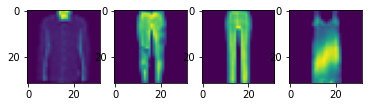

The new barycenter


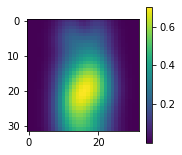

Tracking distance between new barycenter and previous barycenter :  tensor(0.1121)
Iteration number :  32
Input barycenter : 


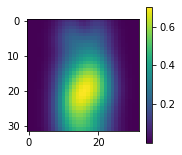

Neighbors of input barycenter :



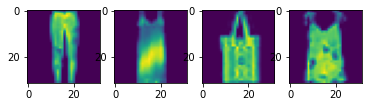

The new barycenter


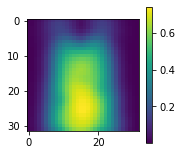

Tracking distance between new barycenter and previous barycenter :  tensor(0.1059)
Iteration number :  33
Input barycenter : 


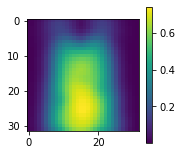

Neighbors of input barycenter :



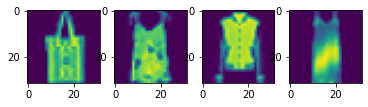

The new barycenter


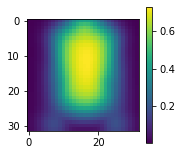

Tracking distance between new barycenter and previous barycenter :  tensor(0.0594)
Iteration number :  34
Input barycenter : 


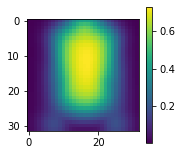

Neighbors of input barycenter :



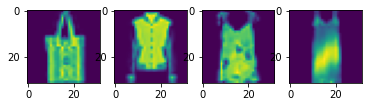

The new barycenter


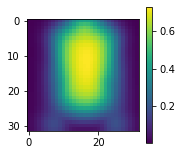

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  35
Input barycenter : 


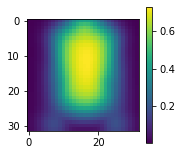

Neighbors of input barycenter :



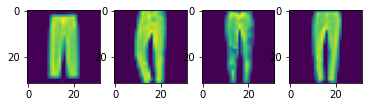

The new barycenter


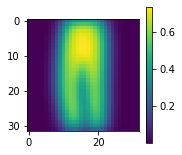

Tracking distance between new barycenter and previous barycenter :  tensor(0.1104)
Iteration number :  36
Input barycenter : 


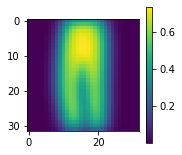

Neighbors of input barycenter :



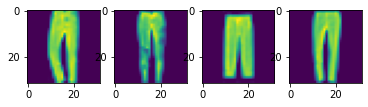

The new barycenter


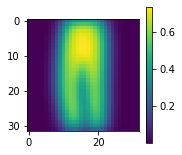

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  37
Input barycenter : 


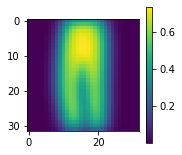

Neighbors of input barycenter :



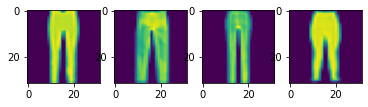

The new barycenter


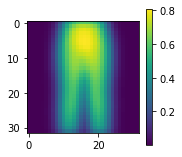

Tracking distance between new barycenter and previous barycenter :  tensor(0.0501)
Iteration number :  38
Input barycenter : 


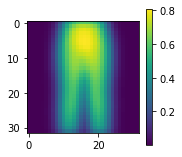

Neighbors of input barycenter :



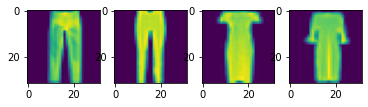

The new barycenter


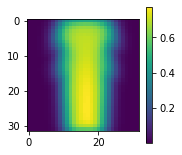

Tracking distance between new barycenter and previous barycenter :  tensor(0.0881)
Iteration number :  39
Input barycenter : 


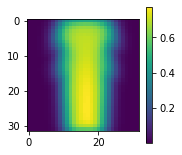

Neighbors of input barycenter :



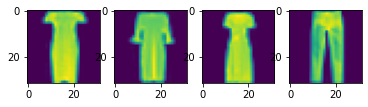

The new barycenter


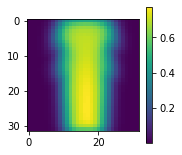

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  40
Input barycenter : 


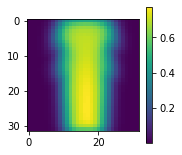

Neighbors of input barycenter :



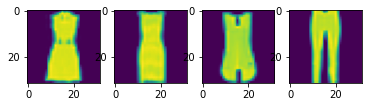

The new barycenter


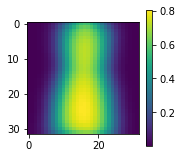

Tracking distance between new barycenter and previous barycenter :  tensor(0.0524)
Iteration number :  41
Input barycenter : 


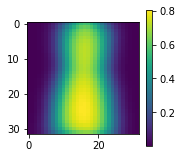

Neighbors of input barycenter :



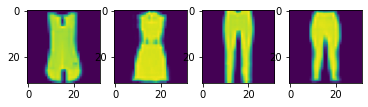

The new barycenter


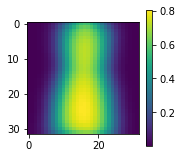

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  42
Input barycenter : 


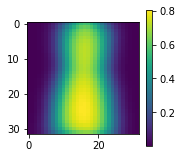

Neighbors of input barycenter :



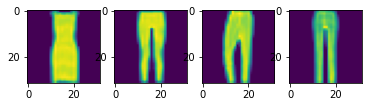

The new barycenter


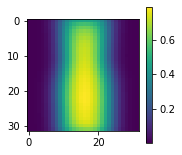

Tracking distance between new barycenter and previous barycenter :  tensor(0.0404)
Iteration number :  43
Input barycenter : 


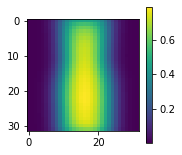

Neighbors of input barycenter :



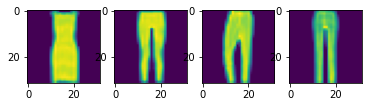

The new barycenter


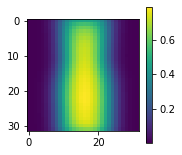

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  44
Input barycenter : 


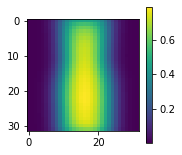

Neighbors of input barycenter :



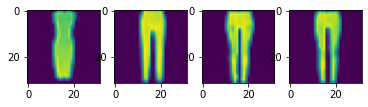

The new barycenter


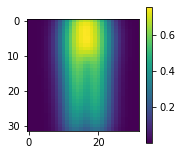

Tracking distance between new barycenter and previous barycenter :  tensor(0.0984)
Iteration number :  45
Input barycenter : 


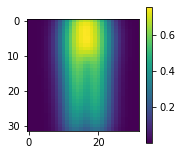

Neighbors of input barycenter :



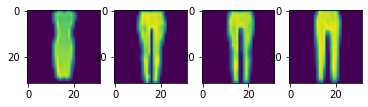

The new barycenter


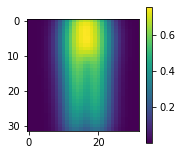

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  46
Input barycenter : 


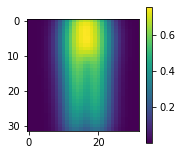

Neighbors of input barycenter :



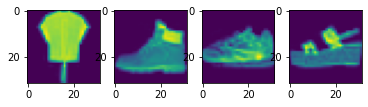

The new barycenter


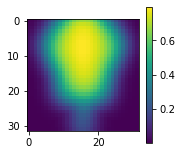

Tracking distance between new barycenter and previous barycenter :  tensor(0.1633)
Iteration number :  47
Input barycenter : 


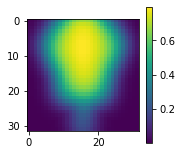

Neighbors of input barycenter :



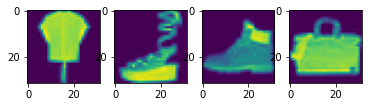

The new barycenter


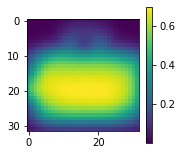

Tracking distance between new barycenter and previous barycenter :  tensor(0.1617)
Iteration number :  48
Input barycenter : 


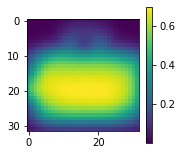

Neighbors of input barycenter :



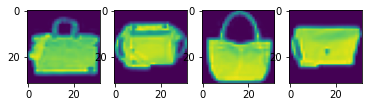

The new barycenter


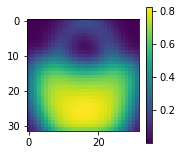

Tracking distance between new barycenter and previous barycenter :  tensor(0.0836)
Iteration number :  49
Input barycenter : 


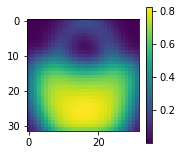

Neighbors of input barycenter :



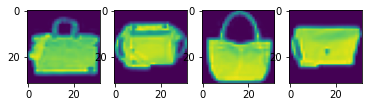

The new barycenter


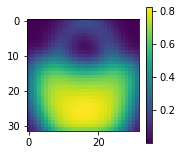

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  50
Input barycenter : 


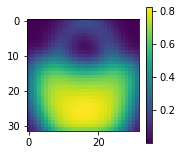

Neighbors of input barycenter :



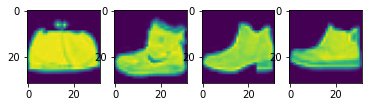

The new barycenter


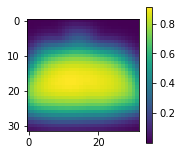

Tracking distance between new barycenter and previous barycenter :  tensor(0.1069)
Iteration number :  51
Input barycenter : 


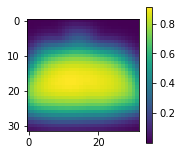

Neighbors of input barycenter :



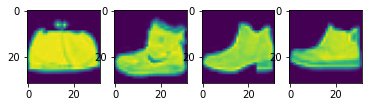

The new barycenter


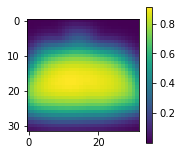

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  52
Input barycenter : 


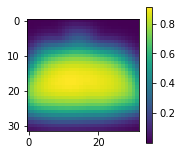

Neighbors of input barycenter :



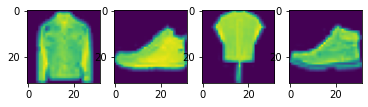

The new barycenter


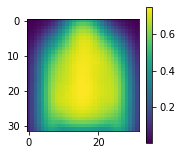

Tracking distance between new barycenter and previous barycenter :  tensor(0.2455)
Iteration number :  53
Input barycenter : 


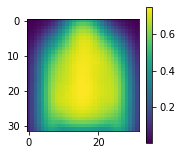

Neighbors of input barycenter :



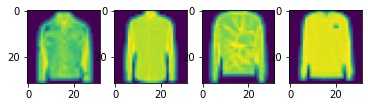

The new barycenter


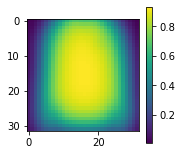

Tracking distance between new barycenter and previous barycenter :  tensor(0.1368)
Iteration number :  54
Input barycenter : 


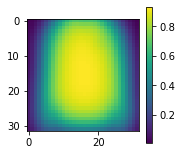

Neighbors of input barycenter :



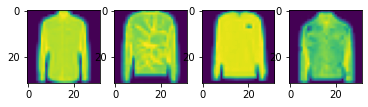

The new barycenter


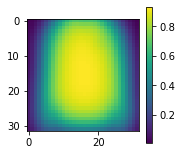

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  55
Input barycenter : 


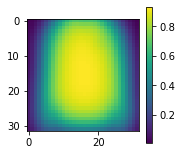

Neighbors of input barycenter :



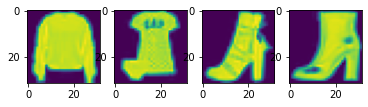

The new barycenter


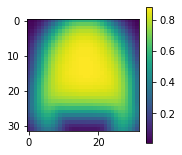

Tracking distance between new barycenter and previous barycenter :  tensor(0.1250)
Iteration number :  56
Input barycenter : 


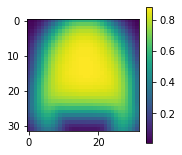

Neighbors of input barycenter :



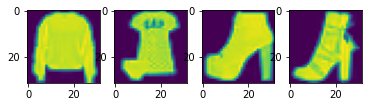

The new barycenter


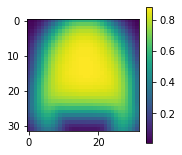

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  57
Input barycenter : 


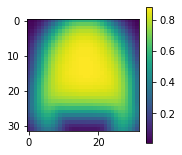

Neighbors of input barycenter :



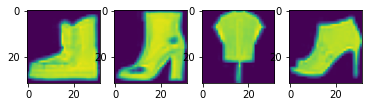

The new barycenter


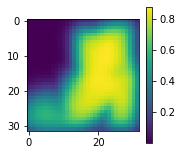

Tracking distance between new barycenter and previous barycenter :  tensor(0.2530)
Iteration number :  58
Input barycenter : 


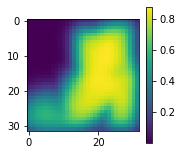

Neighbors of input barycenter :



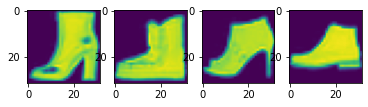

The new barycenter


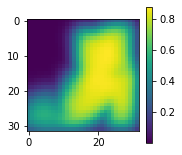

Tracking distance between new barycenter and previous barycenter :  tensor(0.0083)
Iteration number :  59
Input barycenter : 


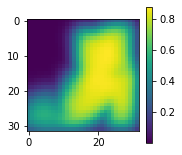

Neighbors of input barycenter :



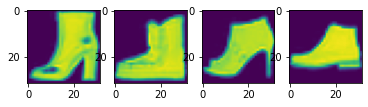

The new barycenter


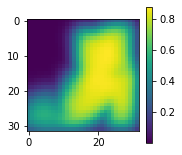

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  60
Input barycenter : 


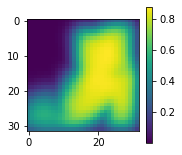

Neighbors of input barycenter :



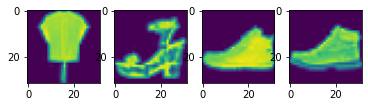

The new barycenter


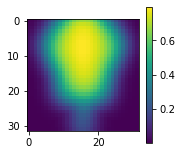

Tracking distance between new barycenter and previous barycenter :  tensor(0.3179)
Iteration number :  61
Input barycenter : 


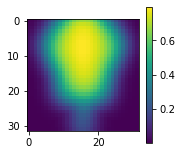

Neighbors of input barycenter :



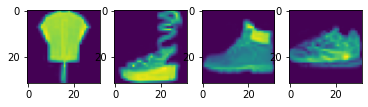

The new barycenter


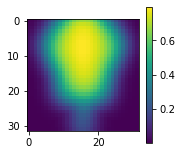

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  62
Input barycenter : 


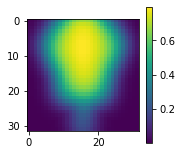

Neighbors of input barycenter :



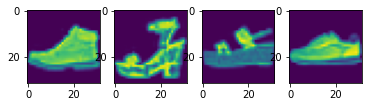

The new barycenter


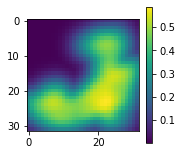

Tracking distance between new barycenter and previous barycenter :  tensor(0.1928)
Iteration number :  63
Input barycenter : 


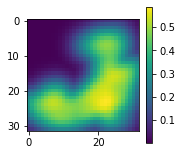

Neighbors of input barycenter :



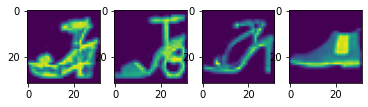

The new barycenter


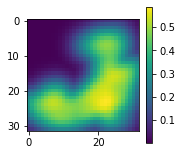

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  64
Input barycenter : 


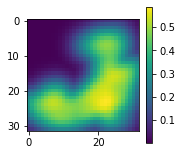

Neighbors of input barycenter :



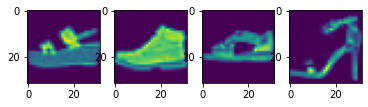

The new barycenter


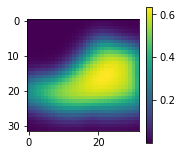

Tracking distance between new barycenter and previous barycenter :  tensor(0.1116)
Iteration number :  65
Input barycenter : 


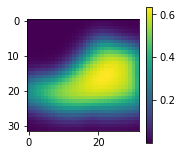

Neighbors of input barycenter :



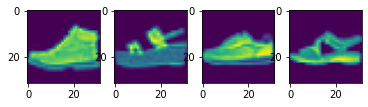

The new barycenter


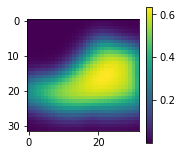

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  66
Input barycenter : 


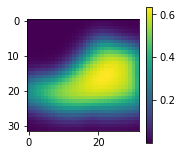

Neighbors of input barycenter :



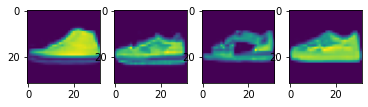

The new barycenter


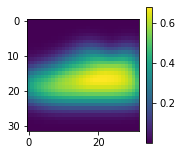

Tracking distance between new barycenter and previous barycenter :  tensor(0.0788)
Iteration number :  67
Input barycenter : 


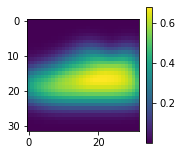

Neighbors of input barycenter :



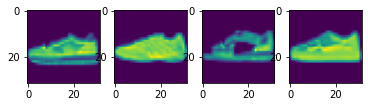

The new barycenter


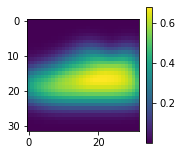

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  68
Input barycenter : 


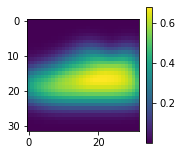

Neighbors of input barycenter :



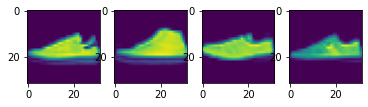

The new barycenter


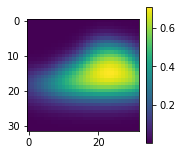

Tracking distance between new barycenter and previous barycenter :  tensor(0.0765)
Iteration number :  69
Input barycenter : 


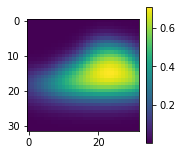

Neighbors of input barycenter :



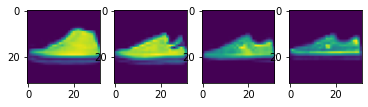

The new barycenter


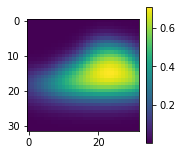

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  70
Input barycenter : 


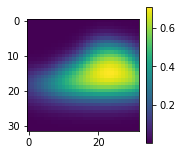

Neighbors of input barycenter :



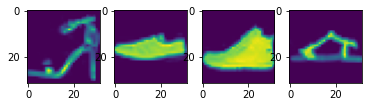

The new barycenter


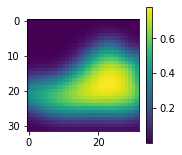

Tracking distance between new barycenter and previous barycenter :  tensor(0.1159)
Iteration number :  71
Input barycenter : 


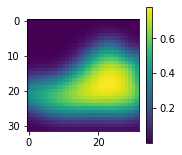

Neighbors of input barycenter :



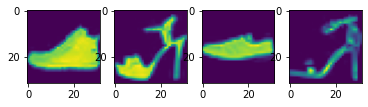

The new barycenter


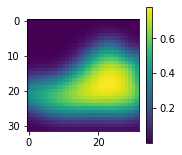

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
Iteration number :  72
Input barycenter : 


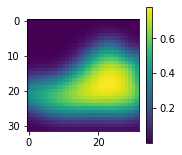

Neighbors of input barycenter :



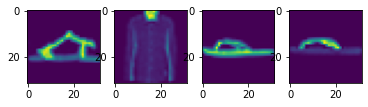

The new barycenter


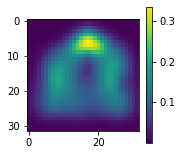

Tracking distance between new barycenter and previous barycenter :  tensor(0.3311)
Iteration number :  73
Input barycenter : 


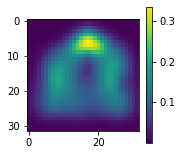

Neighbors of input barycenter :



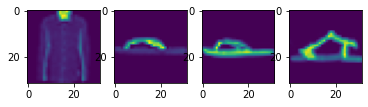

The new barycenter


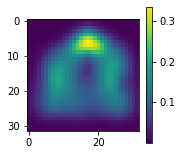

Tracking distance between new barycenter and previous barycenter :  tensor(0.)
END


In [8]:
#Demo of barycenter convergence

bary = batch_x[0][0]
rem_indices = np.array(range(0,batch_x.shape[0]))
#Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
print("Size of batch : ", batch_x.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
covered_indices = np.array([])

for i in range(int(batch_x.shape[0])):
    
    if(len(rem_indices) < 4):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    
    old_bary = bary
    

    
    neighbours, bary, rem_indices = ImageDistancesFromBarycenter_sliced(batch_x, torch.tensor(bary), rem_indices)
    


    print("Neighbors of input barycenter :")
    print()
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(torch.tensor(neighbours[0]).view(32,32))
    axarr[1].imshow(torch.tensor(neighbours[1]).view(32,32))
    axarr[2].imshow(torch.tensor(neighbours[2]).view(32,32))
    axarr[3].imshow(torch.tensor(neighbours[3]).view(32,32))
    plt.show()

    print("The new barycenter")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    

    bary = torch.tensor(bary)

    wassDistance = ot.sliced_wasserstein_distance(old_bary, bary, seed=0)  
    
    #covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)
    covered_indices = rem_indices[:4] 


    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance == 0.0):

        unique_covered_indices = np.unique(covered_indices, axis=0)
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

        s1 = set(rem_indices)
        s2 = set(unique_covered_indices)
        rem_set = s1 - s2
        rem_inds = list(rem_set)
        rem_indices = rem_set

sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]*sampled_barycenters.shape[1])/1024), 32, 32)


In [9]:
sampled_barycenters.shape

torch.Size([30, 32, 32])

/tmp/ipykernel_22399/2811262560.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))


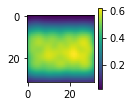

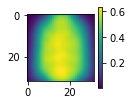

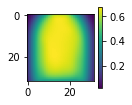

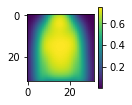

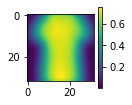

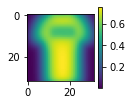

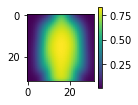

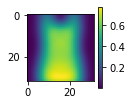

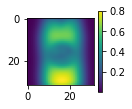

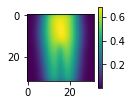

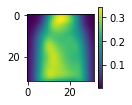

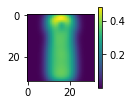

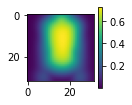

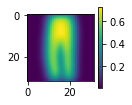

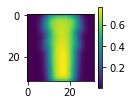

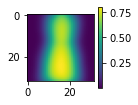

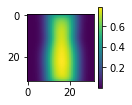

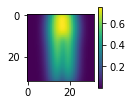

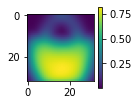

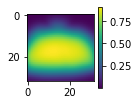

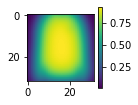

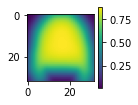

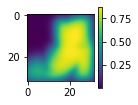

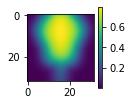

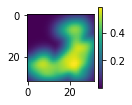

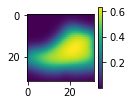

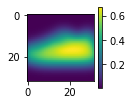

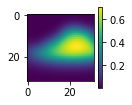

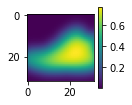

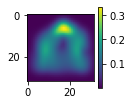

In [10]:
# printing all sampled barycenters
for i in range(sampled_barycenters.shape[0]):    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))
    plt.colorbar()
    plt.show()

In [11]:
#Computing wasserstein distance matrix for barycenters to calculate Persistent homology

wass_dist_matrix = np.zeros((sampled_barycenters.shape[0], sampled_barycenters.shape[0]))
for i in range(sampled_barycenters.shape[0]):
    for j in range(sampled_barycenters.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            wassDistance = ot.sliced_wasserstein_distance(sampled_barycenters[i], sampled_barycenters[j], seed=0)  

            wass_dist_matrix[j, i] = wassDistance


In [12]:
wass_dist_matrix.shape 

(30, 30)

In [13]:
diagrams = ripser.ripser(wass_dist_matrix, distance_matrix=True, maxdim=8)['dgms']


In [14]:
diagrams

[array([[0.        , 0.02803882],
        [0.        , 0.03619494],
        [0.        , 0.04412386],
        [0.        , 0.05314717],
        [0.        , 0.05959678],
        [0.        , 0.06199052],
        [0.        , 0.06544423],
        [0.        , 0.066319  ],
        [0.        , 0.06651615],
        [0.        , 0.06847791],
        [0.        , 0.06988168],
        [0.        , 0.07093251],
        [0.        , 0.07100325],
        [0.        , 0.07522719],
        [0.        , 0.07886904],
        [0.        , 0.07906342],
        [0.        , 0.08039249],
        [0.        , 0.08109406],
        [0.        , 0.09084775],
        [0.        , 0.10221284],
        [0.        , 0.10407858],
        [0.        , 0.10657186],
        [0.        , 0.10737731],
        [0.        , 0.12464727],
        [0.        , 0.12532473],
        [0.        , 0.12640074],
        [0.        , 0.1679334 ],
        [0.        , 0.17127939],
        [0.        , 0.22739153],
        [0.   

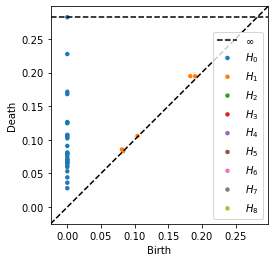

In [15]:
#Persistent homology

plot_diagrams(diagrams, show=True)

In [16]:
# Persistent homology calculation using l2 distance between barycenters

In [17]:
dist_mat_FMNIST = _compute_distance_matrix(sampled_barycenters, p=2)

/tmp/ipykernel_22399/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


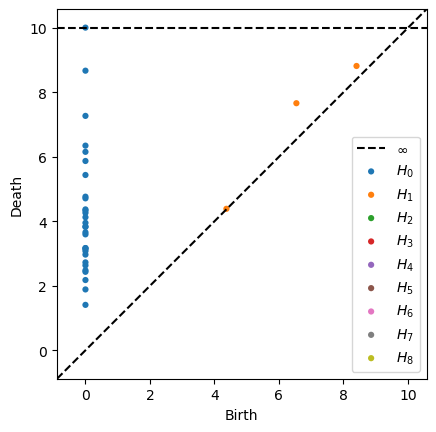

In [18]:
dig, PH_diagram_barycenters = get_persistence_diagram(sampled_barycenters,8)

In [19]:
dig

[array([[0.        , 1.40891004],
        [0.        , 1.88771486],
        [0.        , 2.17921209],
        [0.        , 2.43429255],
        [0.        , 2.47978568],
        [0.        , 2.63418961],
        [0.        , 2.72674513],
        [0.        , 2.96867418],
        [0.        , 3.07772374],
        [0.        , 3.13960576],
        [0.        , 3.16868687],
        [0.        , 3.17114139],
        [0.        , 3.59581494],
        [0.        , 3.65942359],
        [0.        , 3.82788301],
        [0.        , 3.83763838],
        [0.        , 3.95300221],
        [0.        , 4.12640667],
        [0.        , 4.26293993],
        [0.        , 4.33430672],
        [0.        , 4.37012386],
        [0.        , 4.71301651],
        [0.        , 4.76479435],
        [0.        , 5.43753147],
        [0.        , 5.87171745],
        [0.        , 6.15555954],
        [0.        , 6.34801817],
        [0.        , 7.27053976],
        [0.        , 8.67285538],
        [0.   